In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
moma_sample = pd.read_csv("../data/moma_sample.csv")

In [4]:
moma_sample.head()

,artist,country,birth,death,alive,genx,gender,count,year_acquired_min,year_acquired_max
0,Ad Gerritsen,dutch,1940,2015.0,False,False,male,1,1981,1981
1,Kirstine Roepstorff,danish,1972,NaN,True,True,female,3,2005,2005
2,Lisa Baumgardner,american,1958,2015.0,False,False,female,2,2016,2016
3,David Bates,american,1952,NaN,True,False,male,1,2001,2001
4,Simon Levy,american,1946,NaN,True,False,male,1,2012,2012


In [5]:
result = moma_sample["genx"].value_counts()
print(result)

genx
False    86
True     14
Name: count, dtype: int64


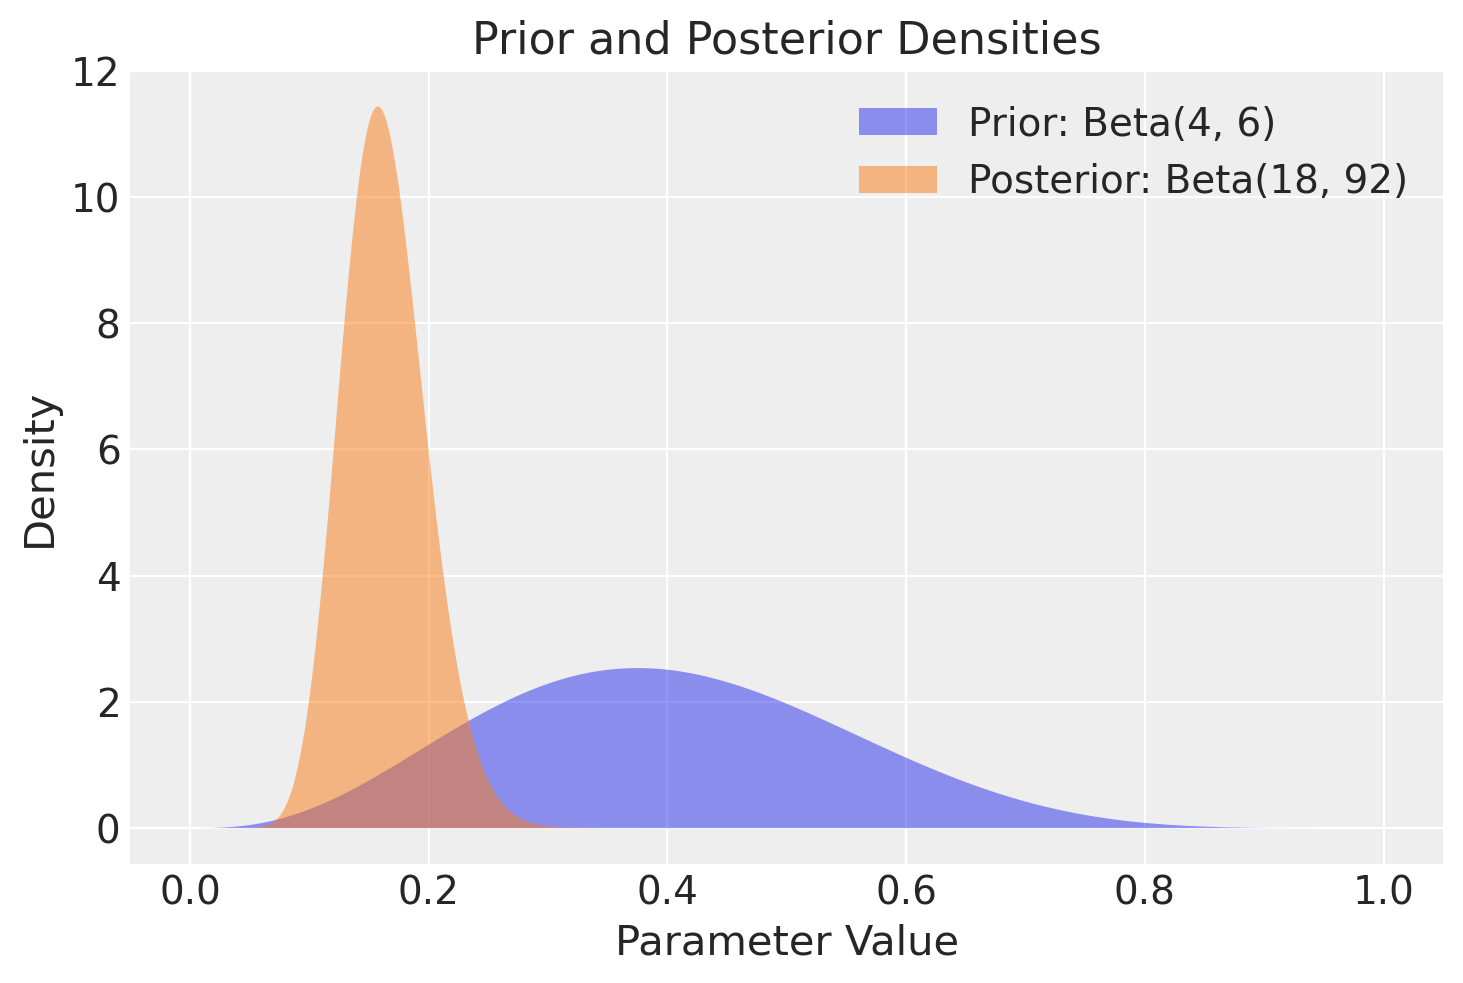

In [6]:
x = np.linspace(0, 1, 1000)

prior_density = stats.beta.pdf(x, 4, 6)
posterior_density = stats.beta.pdf(x, 18, 92)

plt.fill_between(x, prior_density, alpha=0.5, label="Prior: Beta(4, 6)")
plt.fill_between(x, posterior_density, alpha=0.5, label="Posterior: Beta(18, 92)")
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.legend()
plt.title("Prior and Posterior Densities")
plt.show()

In [7]:
y = stats.beta(18, 92).rvs(10)
print(*y)

0.19493378650427373 0.20018872184157438 0.15505016064600155 0.12617206580873055 0.1629034546407364 0.1822700531311704 0.17917777183281108 0.18408680693924714 0.19203957941062205 0.10667073363232665


In [8]:
y.mean()

0.1683493134387494

In [9]:
stats.beta(18, 92).rvs(10000).mean()

0.1631753790166631

In [10]:
# Proposal distribution
def uniprop(xprev, delta=0.05):
    return xprev + stats.uniform.rvs(loc=-delta, scale=2 * delta)

In [11]:
# Metropolis algorithm 
def metropolis_v1(p, qdraw, nsamp, xinit):
    """
    Implements the Metropolis algorithm for MCMC sampling.

    The function generates `nsamp` samples from a target distribution `p` using 
    the Metropolis algorithm. The algorithm starts with an initial state `xinit` 
    and iteratively applies a proposal mechanism governed by `qdraw` to explore 
    the target distribution.

    Args:
        p (callable): A function representing the target distribution to sample from.
                     Should accept a float or array-like and return the density 
                     (unnormalized is okay) at that point.
                     
        qdraw (callable): A function implementing the proposal mechanism. 
                          Takes the current state (float or array-like) as input 
                          and returns a proposed next state.
                          
        nsamp (int): The number of samples to draw from the target distribution.
        
        xinit (float or array-like): The initial state for the MCMC chain.

    Returns:
        numpy.ndarray: An array of shape (nsamp,) containing samples drawn from the 
        target distribution `p`.

    Example:
        >>> import numpy as np
        >>> from scipy import stats
        >>> target = stats.norm().pdf  # Standard Normal as target
        >>> qdraw = lambda x: x + np.random.normal(0, 1)  # Random-walk Metropolis
        >>> samples = metropolis_v1(target, qdraw, 10000, 0.0)
    """
    samples = np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star / p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
        else:
            samples[i] = x_prev
    return samples

In [12]:
# Initialization
init_state = 0.5
n_samples = 100000

In [13]:
# Using Beta(18, 92) as the target distribution
samps = metropolis_v1(lambda x: stats.beta.pdf(x, 18, 92), uniprop, n_samples, init_state)

In [14]:
print(samps[0:20])

[0.47661634 0.44033671 0.44033671 0.45463617 0.45463617 0.44261512
 0.42591578 0.40658679 0.40198277 0.40198277 0.40198277 0.40266997
 0.40266997 0.38072726 0.35820542 0.31654056 0.31654056 0.31654056
 0.31654056 0.31654056]


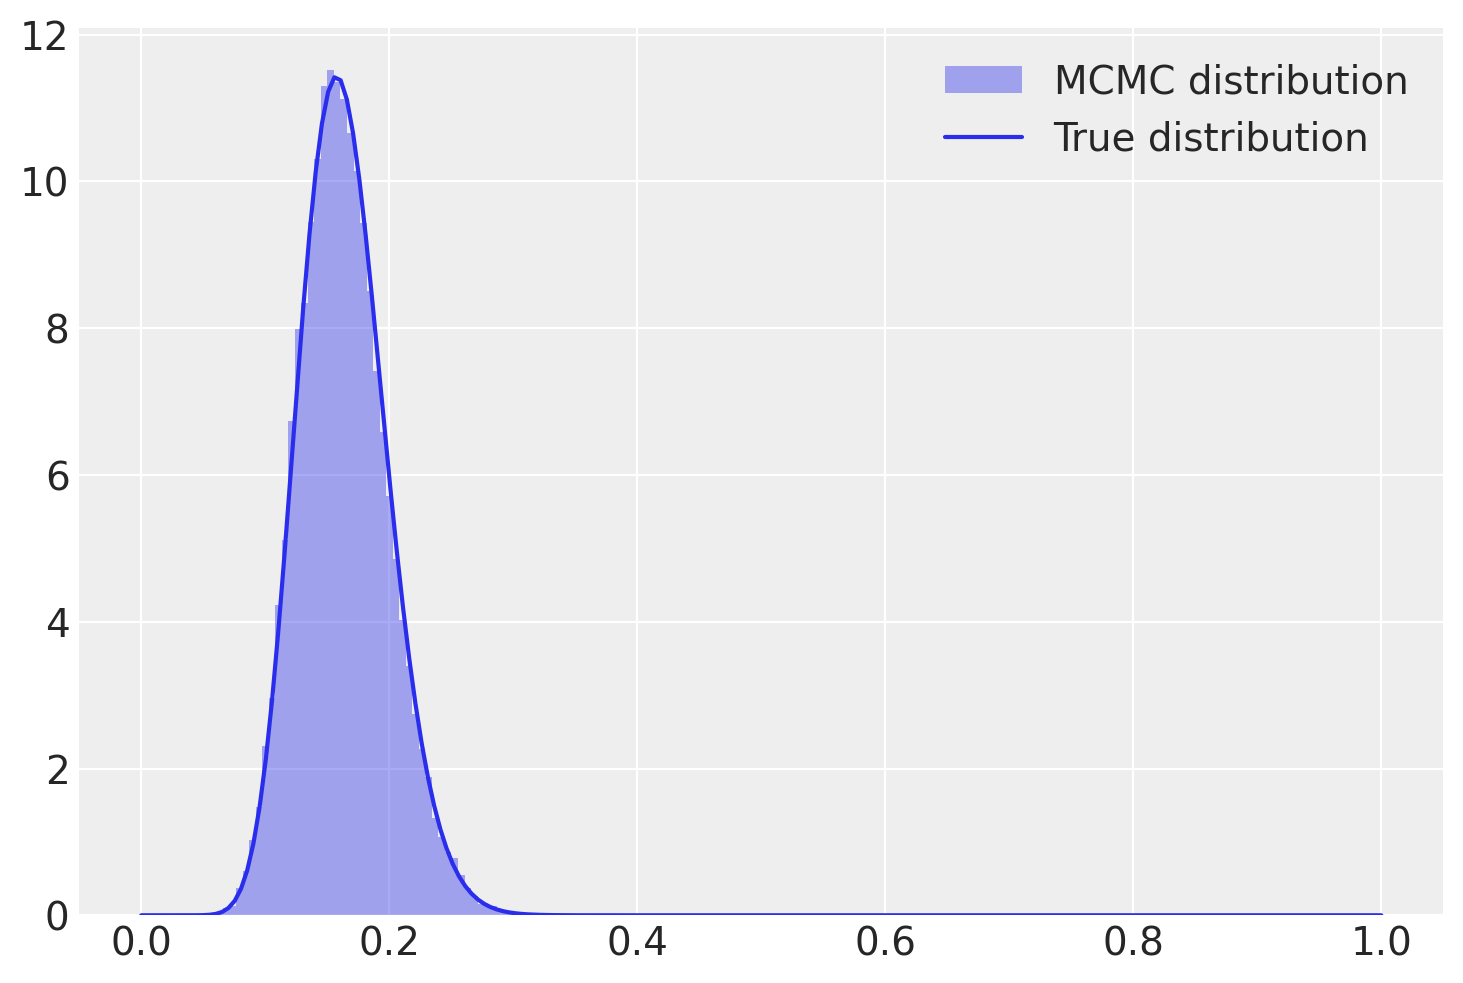

In [15]:
plt.hist(samps, bins=80, alpha=0.4, label="MCMC distribution", density=True)
x = np.linspace(0, 1, 200)
plt.plot(x, stats.beta.pdf(x, 18, 92), "C0", label="True distribution")
plt.legend()
plt.show()

In [16]:
# Proposal distribution
def gaussprop(xprev, sigma=0.1):
    return xprev + stats.norm.rvs(scale=sigma)

In [17]:
samps = metropolis_v1(lambda x: stats.beta.pdf(x, 18, 92), gaussprop, n_samples, init_state)
print(samps[0:20])

[0.5        0.5        0.34448535 0.34448535 0.20953103 0.15277657
 0.15277657 0.15277657 0.15277657 0.15277657 0.15277657 0.21674379
 0.21674379 0.21674379 0.20300415 0.20300415 0.20300415 0.20300415
 0.17080912 0.17080912]


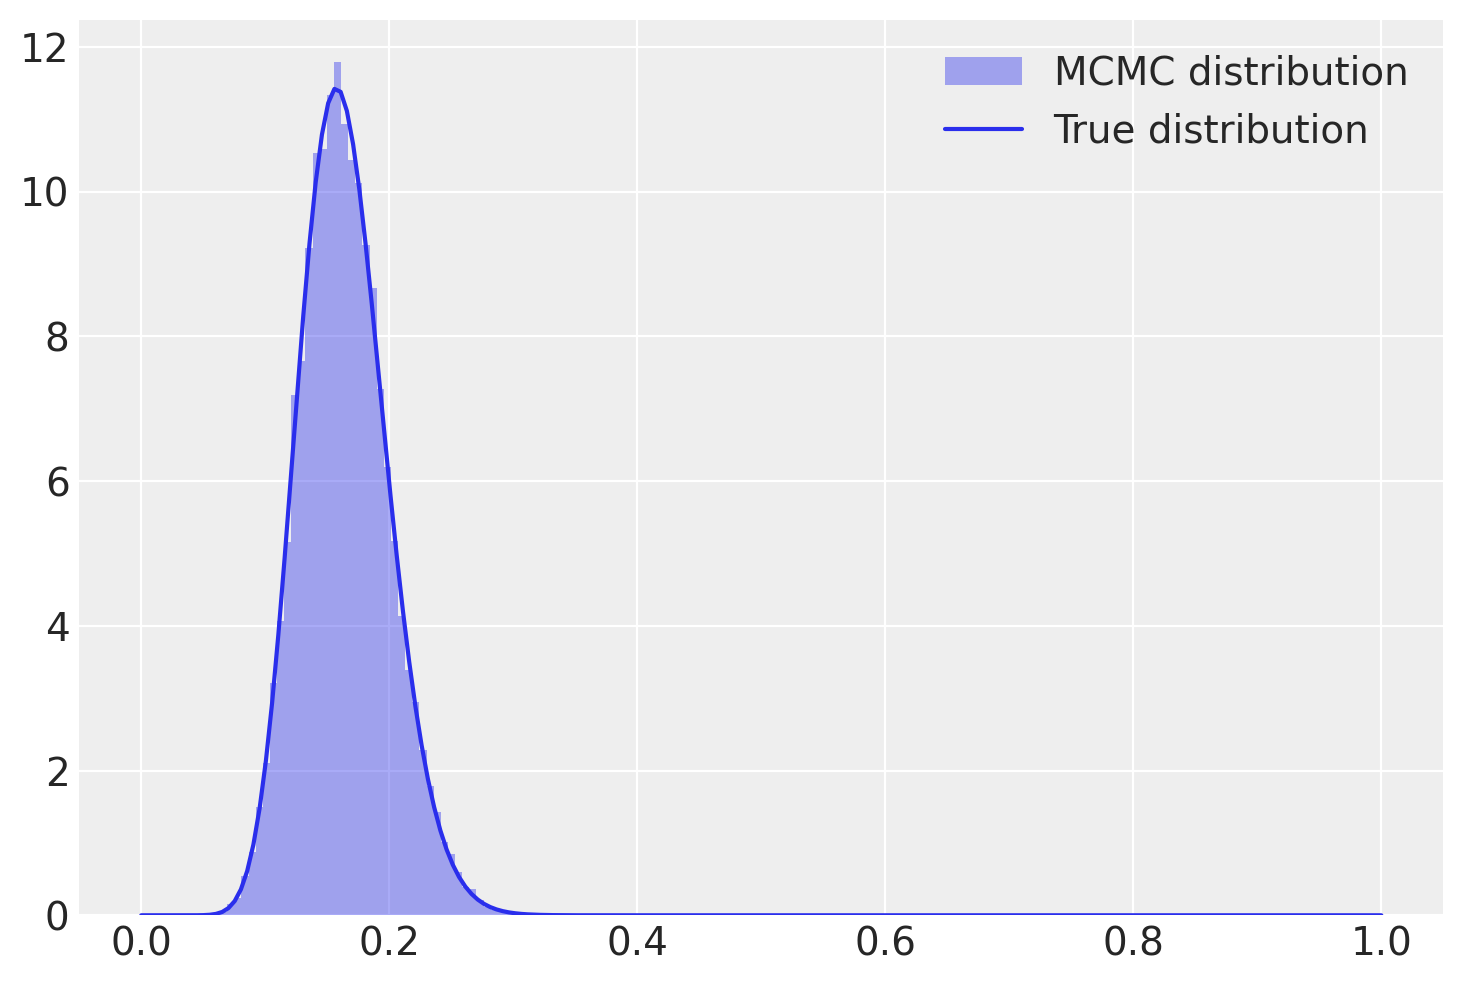

In [18]:
plt.hist(samps, bins=80, alpha=0.4, label="MCMC distribution", density=True)
x = np.linspace(0, 1, 200)
plt.plot(x, stats.beta.pdf(x, 18, 92), "C0", label="True distribution")
plt.legend()
plt.show()

In [19]:
def prior(p):
    alpha = 4
    beta = 6
    return stats.beta.pdf(p, alpha, beta)

In [20]:
def likelihood(p):
    y = 14
    n = 100
    return stats.binom.pmf(y, n, p)

In [21]:
def posterior(p):
    return likelihood(p) * prior(p)

In [22]:
def metropolis_v2(p, qdraw, nsamp, xinit):
    samples = np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        # Check that x_star is within the support of the prior and likelihood
        if 0 <= x_star <= 1:
            p_star = p(x_star)
            p_prev = p(x_prev)
            pdfratio = p_star / p_prev if p_prev > 0 else 1

            if np.random.uniform() < min(1, pdfratio):
                samples[i] = x_star
                x_prev = x_star
            else:
                samples[i] = x_prev
        else:
            samples[i] = x_prev  # reject automatically if outside support
    return samples

In [23]:
# Perform Metropolis sampling
samps = metropolis_v2(posterior, lambda x: gaussprop(x, sigma=0.05), n_samples, init_state)

In [24]:
burnin = int(n_samples * 0.5)
burnin

50000

In [25]:
np.mean(samps[burnin:])

0.16435768723548017

In [26]:
np.std(samps[burnin:])

0.03511223692085333

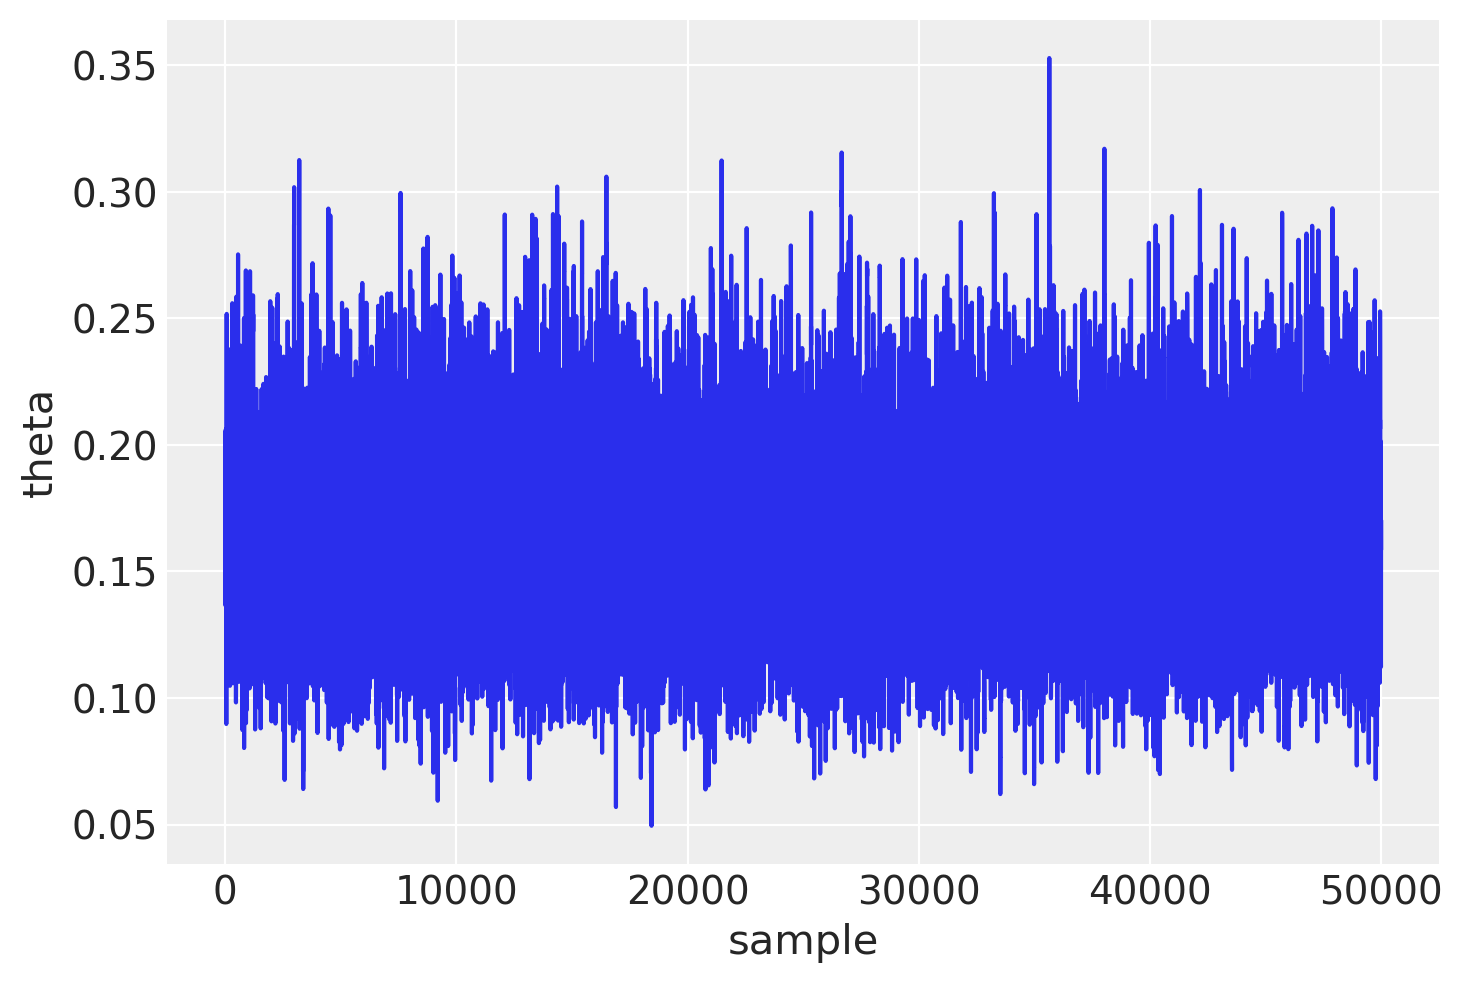

In [27]:
plt.plot(samps[burnin:])
plt.xlabel("sample")
plt.ylabel("theta")
plt.show()

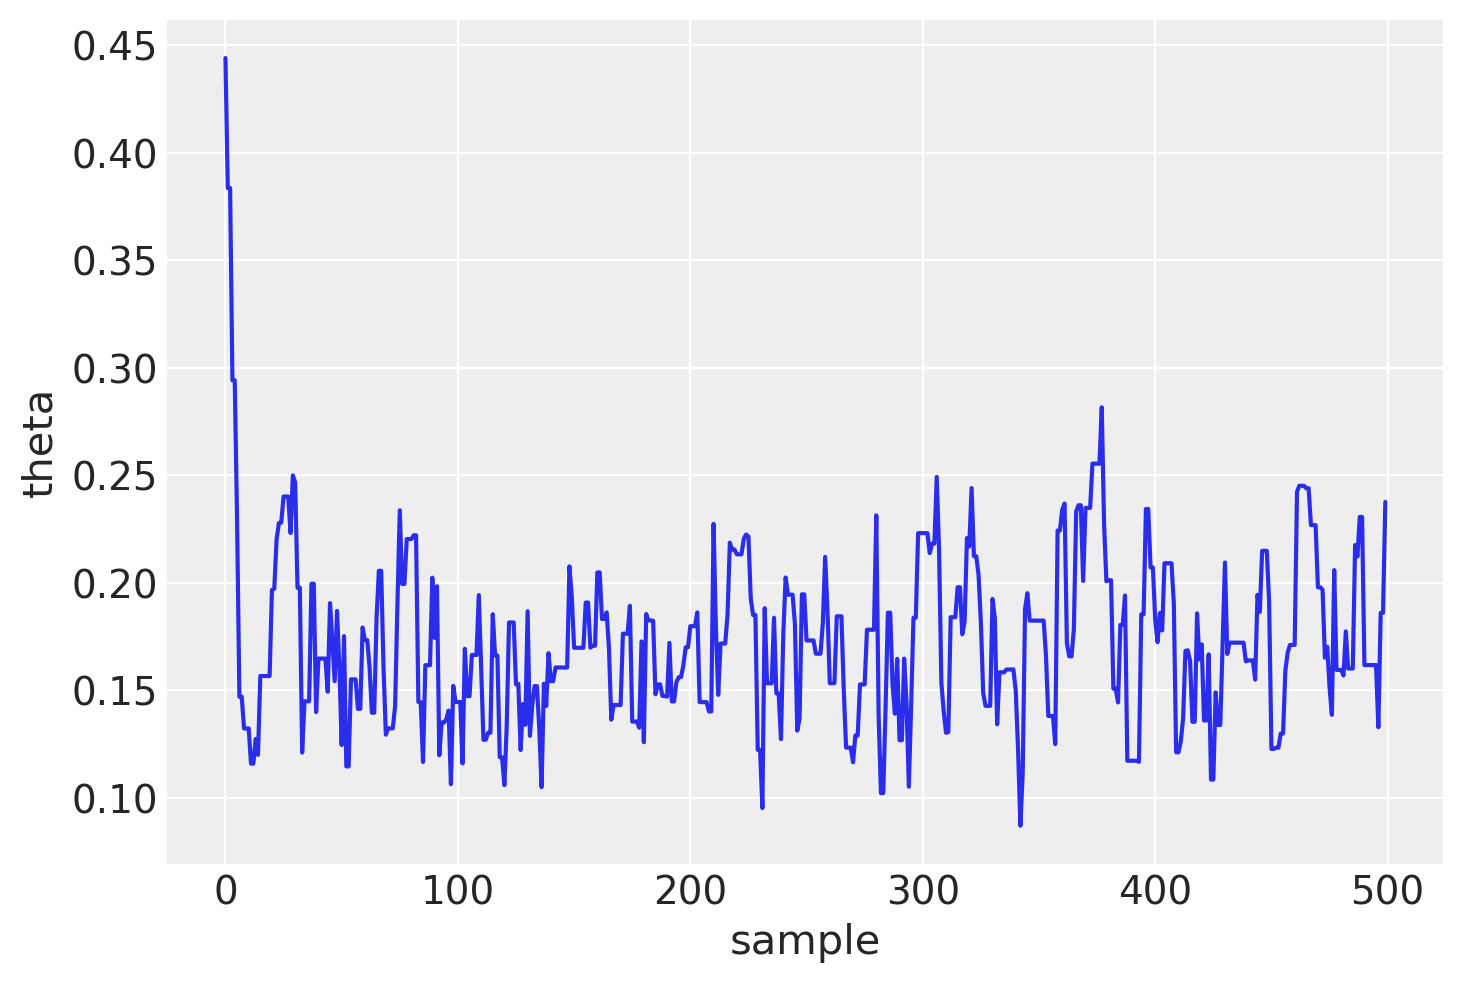

In [28]:
plt.plot(samps[:500])
plt.xlabel("sample")
plt.ylabel("theta")
plt.show()

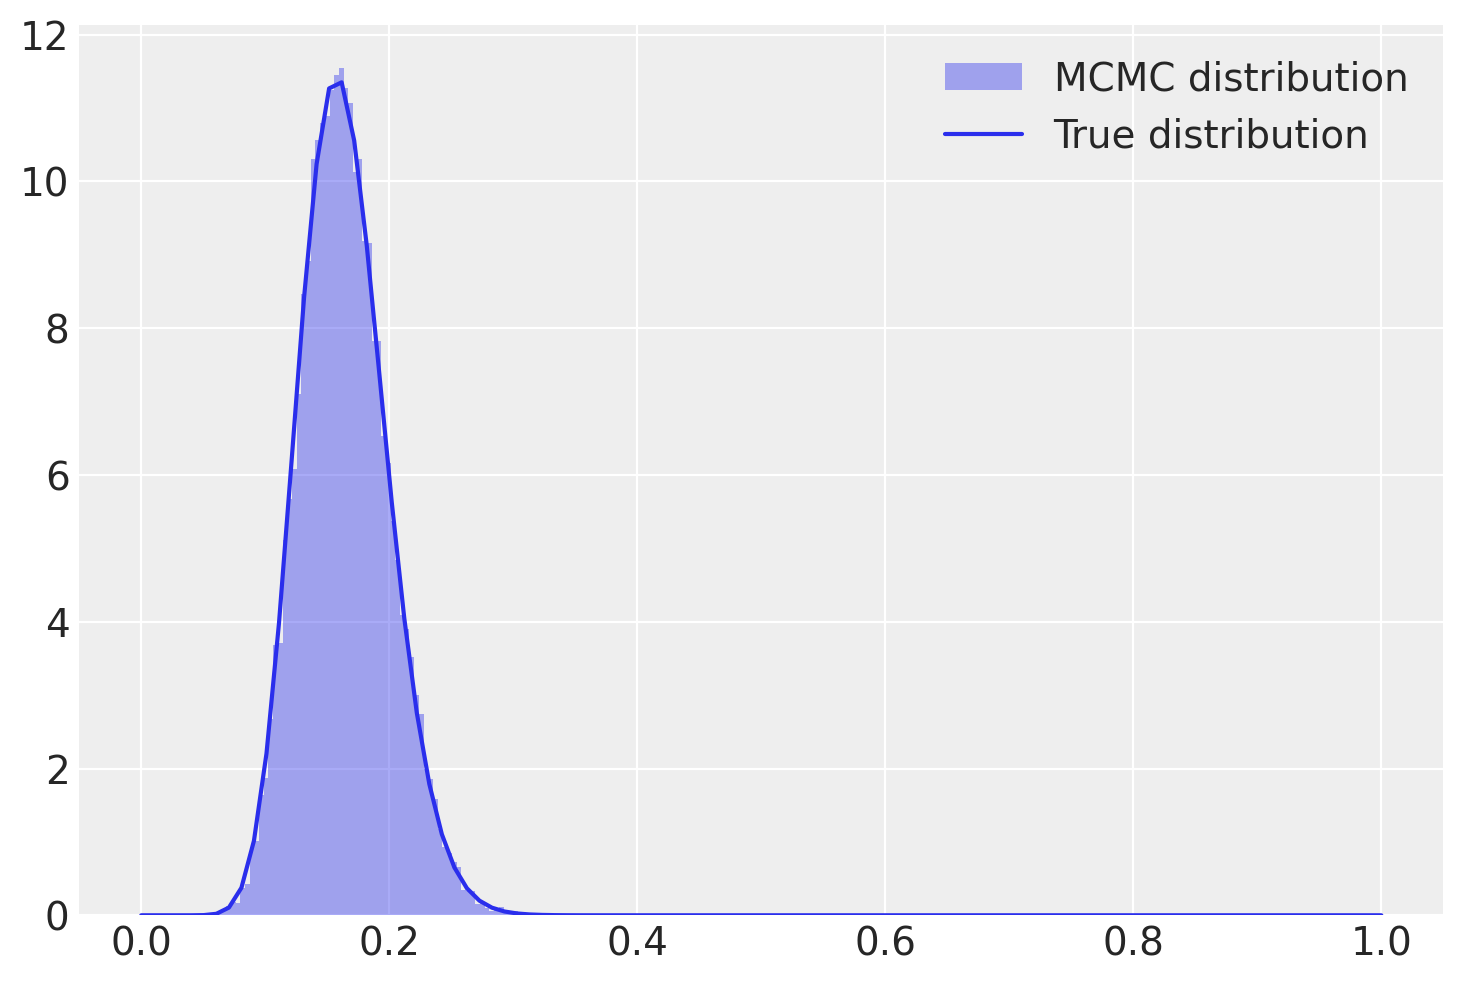

In [29]:
plt.hist(samps[burnin:], bins=80, alpha=0.4, label="MCMC distribution", density=True)
# plot the true function
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, 18, 92), "C0", label="True distribution")
plt.legend()
plt.show()

In [30]:
az.summary(samps[burnin:], kind="stats", hdi_prob=0.94, round_to=2)

,mean,sd,hdi_3%,hdi_97%
x,0.16,0.04,0.1,0.23


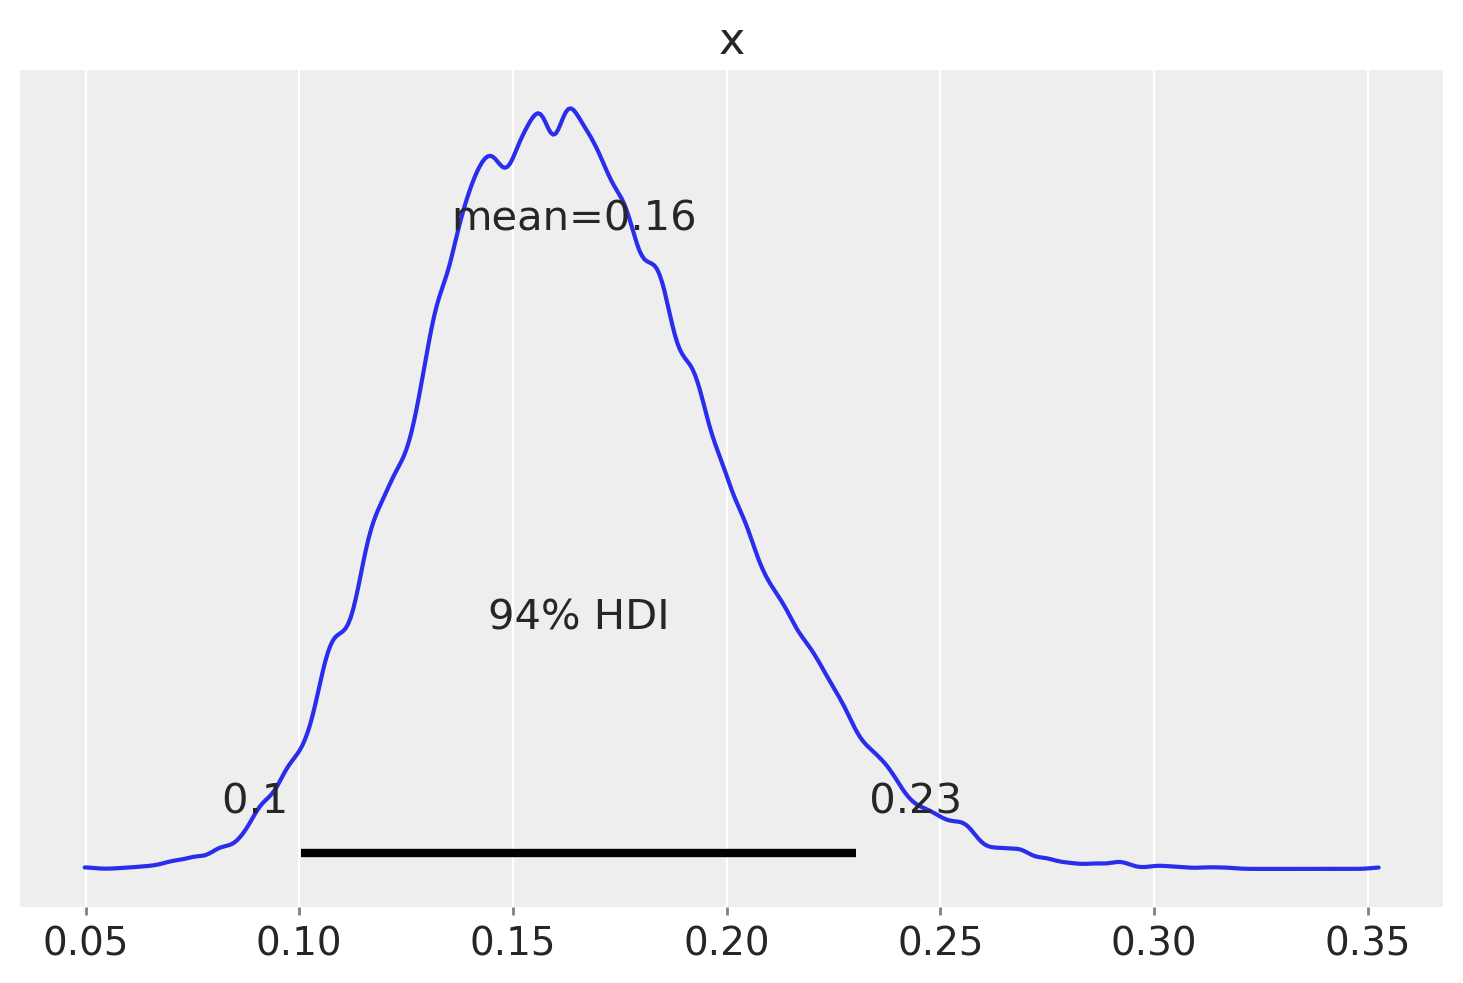

In [31]:
az.plot_posterior(samps[burnin:])
plt.show()

In [32]:
x = pd.array([22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51])
print(*x)

22 24 25 25 28 29 34 37 40 44 51 48 47 50 51


In [33]:
sm.tsa.acf(x)

array([ 1.        ,  0.83174224,  0.65632458,  0.49105012,  0.27863962,
        0.03102625, -0.16527446, -0.30369928, -0.40095465, -0.45823389,
       -0.45047733, -0.36933174])

In [34]:
sm.tsa.acf(x, nlags=4)

array([1.        , 0.83174224, 0.65632458, 0.49105012, 0.27863962])

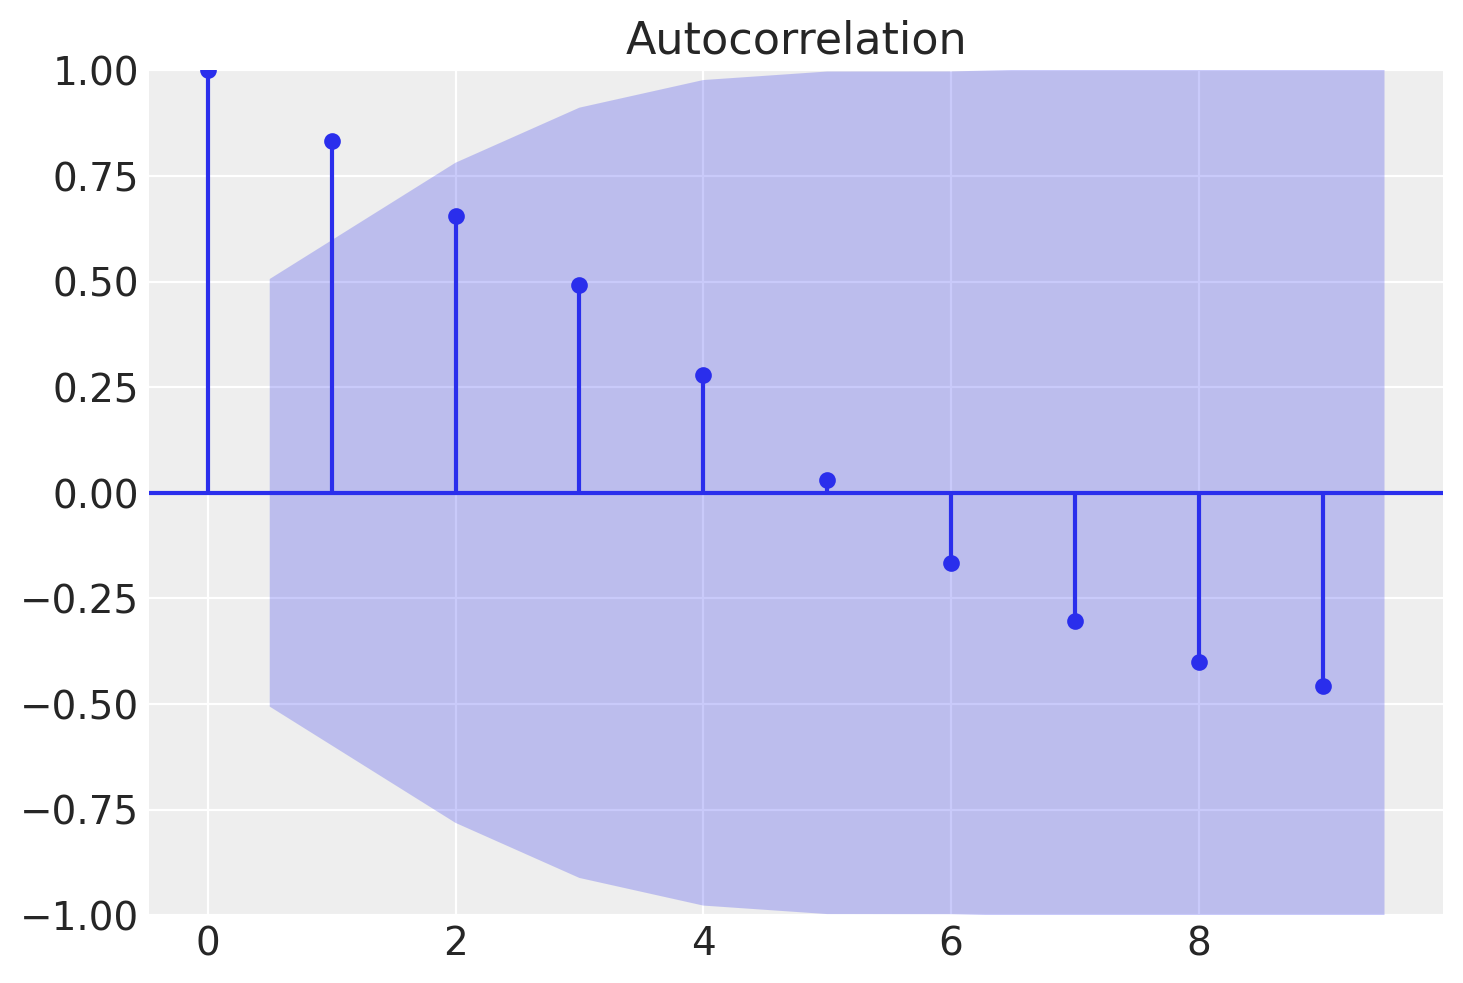

In [35]:
tsaplots.plot_acf(x, lags=9)
plt.show()

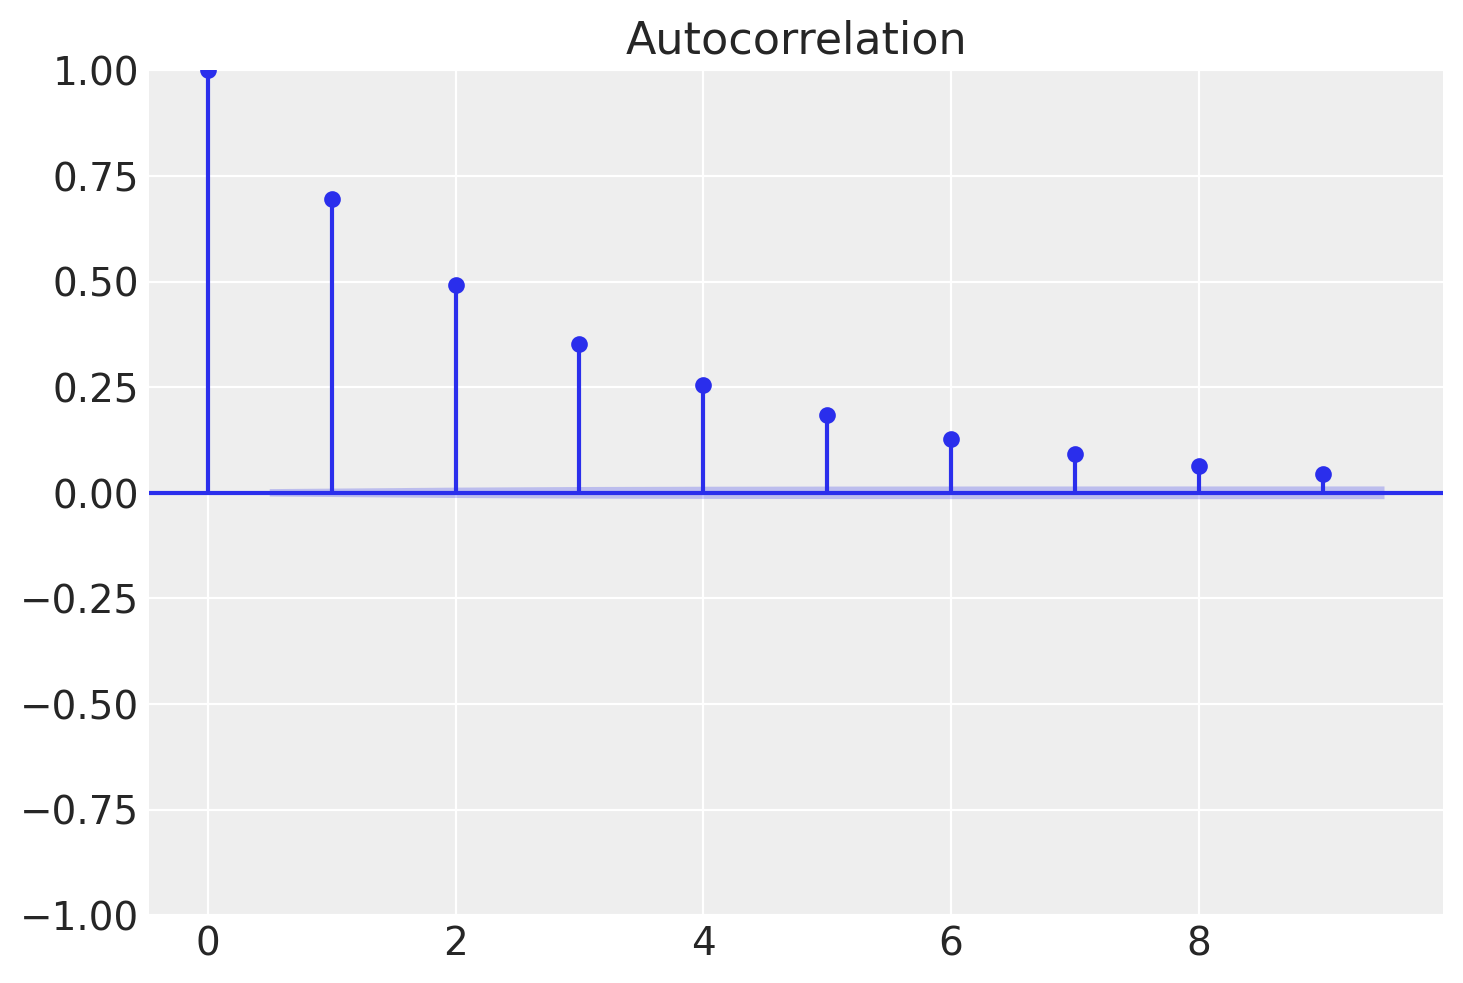

In [36]:
tsaplots.plot_acf(samps[burnin:], lags=9)
plt.show()

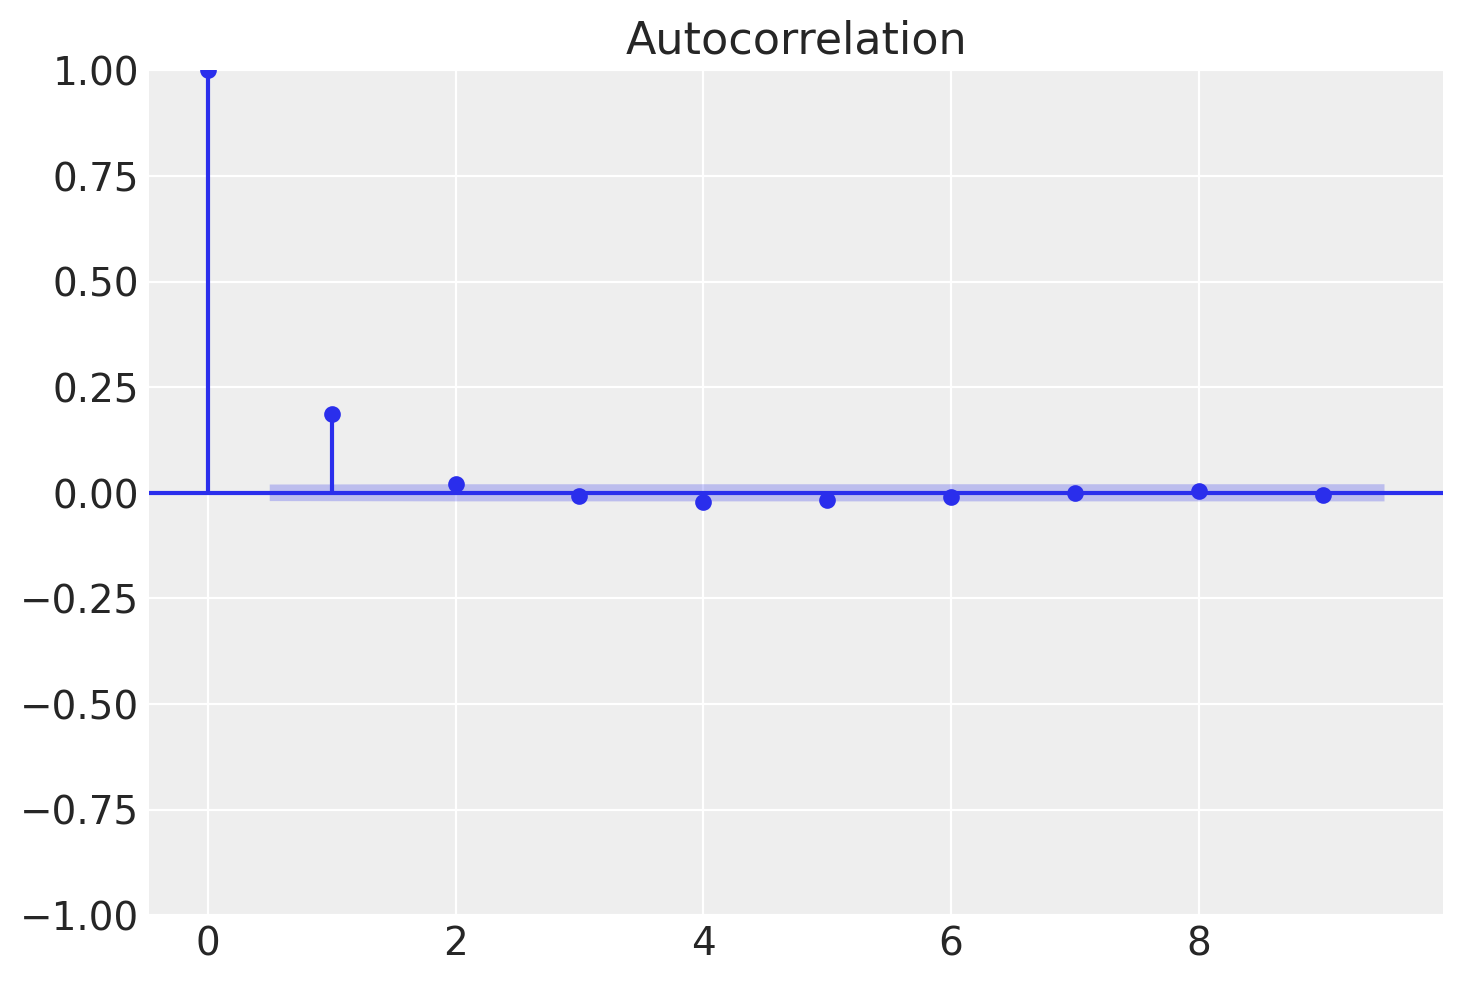

In [37]:
thin=5
sampsthin=samps[burnin::thin]
tsaplots.plot_acf(sampsthin, lags=9)
plt.show()

In [38]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Nov 08 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

numpy      : 1.25.2
scipy      : 1.11.3
pandas     : 2.1.1
statsmodels: 0.14.0
seaborn    : 0.13.0
arviz      : 0.16.1
matplotlib : 3.8.0

Watermark: 2.4.3

